# US Recession Prediction Model

This notebook will make ananalysis of economic indicators from multiple countries

**Approach** 
Binary Classification: since if A recession will occur is a y or n outcome.
Random Forest Classification: to handle non linear relationships if there is any in data and it is robust to messy features.
K-Nearest Neighbors Classifier: This is a good baseline esepcially for smaller datasets such as ours and it also takes past data into consideration making it more accurate.

**Features**
- Yield curve spread (10Y - 3M)
- GDP Growth rates
- Intrest rate levels
- Trade balances
- Lagged features that predict recessions.


# 1.Data Loading

Country and variables map for parsing

In [1]:
# country and variable mapping to make it easier to upload data
country_map = {
    "CH": "ch",
    "EU": "eu",
    "JP": "jp",
    "KR": "kr",
    "UK": "uk",
    "US": "us"
}

variable_map = {
    "TB3MS": "3m",
    "T10YR": "10y",
    "CPI": "cpi",
    "GDP": "gdp",
    "EXP": "exp",
    "IMP": "imp",
    "REC": "rec"
}


In [2]:
# FUNCTIONALITY: Correctly parses dates in data
def smart_parse_dates(series):
  import pandas as pd

  # Excel serial date handling
  if pd.api.types.is_numeric_dtype(series):
    return pd.to_datetime(series, unit="D", origin="1899-12-30", errors="coerce")

  # Convert to string and strip spaces
  series = series.astype(str).str.strip()

  # Try common formats
  formats = [
    "%Y-%m-%d",
    "%Y-%m",
    "%Y/%m/%d",
    "%Y/%m",
    "%b %Y",
    "%Y"
  ]

  for fmt in formats:
    try:
      parsed = pd.to_datetime(series, format=fmt)
      # If at least some rows parsed, assume correct format
      if parsed.notna().sum() > 0:
        return parsed
    except:
      pass

  # Handle formats like "2024M01"
  try:
    series_mod = series.str.replace("M", "-", regex=False)
    parsed = pd.to_datetime(series_mod, format="%Y-%m")
    return parsed
  except:
    pass

  # Fallback
  return pd.to_datetime(series, errors="coerce")


In [3]:
# FUNCTIONALITY: Loads data using specific path
from pathlib import Path
from typing import Union, Optional
import pandas as pd

def load_series_auto(path: Union[str, Path], date_col: Optional[str] = None):
  path = Path(path)
  folder = path.parent.name
  file = path.name

  # detect country
  ccode = file[:2].upper()
  if ccode not in country_map:
    raise ValueError(f"Unknown country code in filename: {file}")
  country = country_map[ccode]

  # detect variable folder
  if folder not in variable_map:
    raise ValueError(f"Unknown variable folder: {folder}")
  variable = variable_map[folder]

  col_name = f"{country}_{variable}"

  # load CSV
  if path.suffix == ".csv":
    # skip metadata lines
    with open(path) as f:
      lines = f.read().splitlines()
    header_index = next((i for i, line in enumerate(lines) if "DATE" in line or "date" in line), 0)
    df = pd.read_csv(path, skiprows=header_index)

  else:
    # handles multiple sheets
    xls = pd.ExcelFile(path)
    df = None

    for sheet in xls.sheet_names:
      temp = pd.read_excel(path, sheet_name=sheet)

      # find a date-like column
      for col in temp.columns:
        if temp[col].astype(str).str.match(r"\d{4}[-/]\d{2}").sum() > 3:
          df = temp
          date_col = col
          break

      if df is not None:
        break

    if df is None:
      # fallback: load first sheet
      df = pd.read_excel(path)
      date_col = df.columns[0]

  # ensure we have a date column
  if date_col is None:
    date_col = df.columns[0]

  # parse dates
  df[date_col] = smart_parse_dates(df[date_col])
  df = df.dropna(subset=[date_col])
  df = df.set_index(date_col).sort_index()

  # rename value column
  value_cols = [c for c in df.columns if c != date_col]
  df = df.rename(columns={value_cols[0]: col_name})

  return df, country, variable

In [4]:
# FUNCTIONALITY: Imports all datasets in 'dataset' into all_sereies
from pathlib import Path

base = Path("dataset")
all_series = []

for folder in base.iterdir():        # e.g. dataset/3M, dataset/CPI
  if folder.is_dir():
    for file in folder.iterdir():    # <-- file declared here
      if file.suffix in [".csv", ".xlsx", ".xls"]:
        df, country, variable = load_series_auto(file)
        all_series.append(df)

In [5]:
# FUNCTIONALITY: Turns all_series into a DataFrame
from functools import reduce

data = reduce(lambda left, right: left.join(right, how="outer"), all_series)
data = data.sort_index()


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052 entries, 1854-12-01 to 2025-11-01
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ch_cpi  388 non-null    float64
 1   eu_cpi  358 non-null    float64
 2   jp_cpi  797 non-null    float64
 3   kr_cpi  767 non-null    float64
 4   uk_cpi  843 non-null    float64
 5   us_cpi  945 non-null    float64
 6   ch_exp  405 non-null    float64
 7   eu_exp  400 non-null    float64
 8   kr_exp  825 non-null    float64
 9   uk_exp  849 non-null    float64
 10  us_exp  314 non-null    float64
 11  ch_gdp  127 non-null    float64
 12  eu_gdp  122 non-null    float64
 13  jp_gdp  831 non-null    float64
 14  kr_gdp  255 non-null    float64
 15  uk_gdp  279 non-null    float64
 16  us_gdp  314 non-null    float64
 17  ch_imp  405 non-null    float64
 18  eu_imp  400 non-null    float64
 19  jp_imp  813 non-null    float64
 20  kr_imp  825 non-null    float64
 21  uk_imp  825 non-nul

# 2.Binary Classification

In [9]:
# FUNCTIONALITY: Cleans data by filtering dates and handling nulls
data = data.loc["1990-01-01":]

# remove CPI columns (avoid inflation skewing)
cpi_cols = [c for c in data.columns if 'cpi' in c]
data = data.drop(columns=cpi_cols)

# forward-fill quarterly data to monthly
data = data.resample('MS').first()
data = data.ffill().bfill().dropna()

print(f"Cleaned data shape: {data.shape}")
print(f"Date range: {data.index.min().strftime('%Y-%m')} to {data.index.max().strftime('%Y-%m')}")
print(f"Recession rate: {data['us_rec'].mean()*100:.1f}%")

Cleaned data shape: (431, 29)
Date range: 1990-01 to 2025-11
Recession rate: 8.4%


In [ ]:
# FUNCTIONALITY: Creates features for recession prediction
import pandas as pd

features = pd.DataFrame(index=data.index)

# yield curve spreads (10Y - 3M) - key recession predictor
features['us_yield_spread'] = data['us_10y'] - data['us_3m']
features['uk_yield_spread'] = data['uk_10y'] - data['uk_3m']
features['eu_yield_spread'] = data['eu_10y'] - data['eu_3m']
features['jp_yield_spread'] = data['jp_10y'] - data['jp_3m']

# interest rate levels
for col in ['us_3m', 'us_10y', 'uk_3m', 'eu_3m', 'jp_3m']:
  features[col] = data[col] 


# GDP growth rates (quarter-over-quarter)
for col in [c for c in data.columns if 'gdp' in c]:
  features[f'{col}_growth'] = data[col].pct_change(periods=3) * 100

# trade balance
features['us_trade_balance'] = data['us_exp'] - data['us_imp']

# lagged features (to predict ahead)
for lag in [3, 6, 12]:
  features[f'us_yield_spread_lag{lag}'] = features['us_yield_spread'].shift(lag)
  features[f'us_gdp_growth_lag{lag}'] = features['us_gdp_growth'].shift(lag)

# rolling stats
features['us_yield_spread_12m_avg'] = features['us_yield_spread'].rolling(12).mean()
features['us_yield_spread_12m_min'] = features['us_yield_spread'].rolling(12).min()

# clean and set target
features = features.dropna()
target = data.loc[features.index, 'us_rec']

print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}")

Features shape: (416, 24)
Target shape: (416,)


In [20]:
# FUNCTIONALITY: Trains logistic regression (binary classification)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# temporal train/test split
split_date = '2015-12-31'
X_train = features[features.index <= split_date]
X_test = features[features.index > split_date]
y_train = target[target.index <= split_date]
y_test = target[target.index > split_date]

print(f"Train: {len(X_train)} obs, Test: {len(X_test)} obs")
print(f"Train recessions: {int(y_train.sum())}, Test recessions: {int(y_test.sum())}")

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train logistic regression
# changed weight class to make it less aggressive (needs stronger evidence for recessions)
model = LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# evaluate
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

# adjust threshold (default is 0.5)
threshold = 0.7  # <-- change this value
y_pred = (y_prob >= threshold).astype(int)

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"\n{classification_report(y_test, y_pred, zero_division=0)}")

Train: 297 obs, Test: 119 obs
Train recessions: 26, Test recessions: 2

AUC-ROC: 0.983
F1 Score: 0.154

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90       117
         1.0       0.08      1.00      0.15         2

    accuracy                           0.82       119
   macro avg       0.54      0.91      0.53       119
weighted avg       0.98      0.82      0.88       119



In [15]:
# FUNCTIONALITY: Gets current recession probability
X_all_scaled = scaler.fit_transform(features)
model.fit(X_all_scaled, target)

# current probability
current_prob = model.predict_proba(X_all_scaled[-1:])[:, 1][0]
latest_date = features.index[-1].strftime('%B %Y')

print(f"Latest data: {latest_date}")
print(f"Current recession probability: {current_prob*100:.1f}%")
print(f"\nKey indicators:")
print(f"  US Yield Spread: {features['us_yield_spread'].iloc[-1]:.2f}%")
print(f"  US GDP Growth:   {features['us_gdp_growth'].iloc[-1]:.1f}%")

Latest data: November 2025
Current recession probability: 12.8%

Key indicators:
  US Yield Spread: 0.31%
  US GDP Growth:   0.0%


In [16]:
# FUNCTIONALITY: Shows probability trend
all_probs = model.predict_proba(X_all_scaled)[:, 1]

print("Recession probability (last 12 months):")
for i in range(-12, 0):
  date = features.index[i].strftime('%Y-%m')
  prob = all_probs[i]
  bar = '█' * int(prob * 20)
  rec = ' ← RECESSION' if target.iloc[i] == 1 else ''
  print(f"  {date}: {prob*100:5.1f}% {bar}{rec}")

Recession probability (last 12 months):
  2024-12:   5.7% █
  2025-01:  16.7% ███
  2025-02:  14.8% ██
  2025-03:  11.1% ██
  2025-04:  10.0% ██
  2025-05:   9.9% █
  2025-06:   8.8% █
  2025-07:  16.7% ███
  2025-08:  18.1% ███
  2025-09:  14.8% ██
  2025-10:  15.2% ███
  2025-11:  12.8% ██


# Plot for Binary Classification

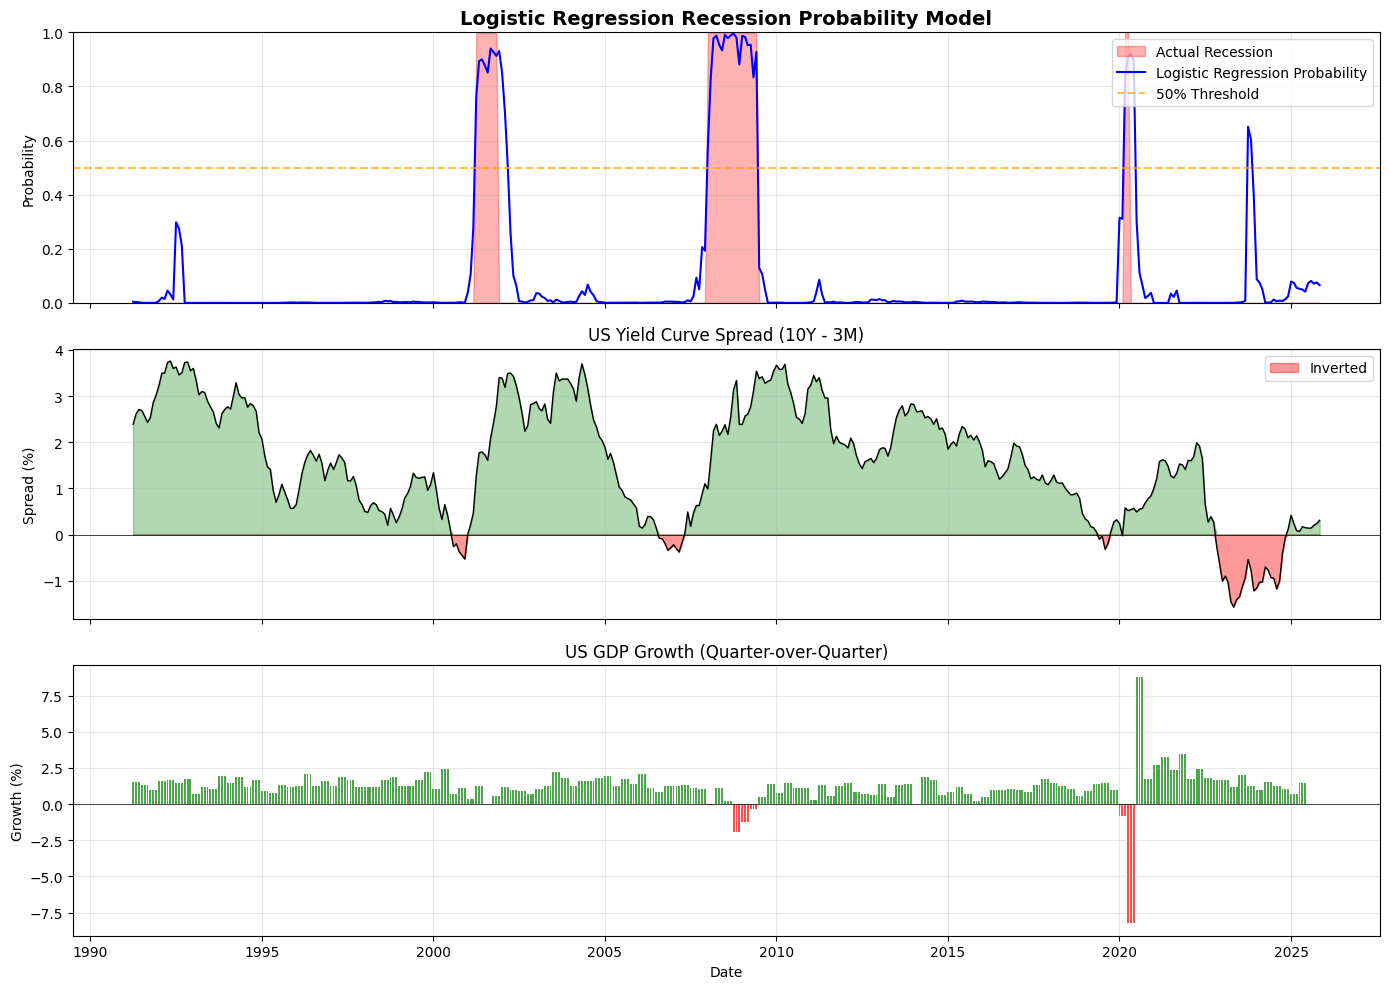

In [24]:
# FUNCTIONALITY: Plots logistic regression recession probability over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# get probabilities for all data
X_all_scaled = scaler.fit_transform(features)
model.fit(X_all_scaled, target)
all_probs = model.predict_proba(X_all_scaled)[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Recession probability
ax1 = axes[0]
ax1.fill_between(features.index, 0, target.values, alpha=0.3, color='red', label='Actual Recession')
ax1.plot(features.index, all_probs, 'b-', linewidth=1.5, label='Logistic Regression Probability')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='50% Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('Logistic Regression Recession Probability Model', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Yield curve spread
ax2 = axes[1]
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(upper=0), alpha=0.4, color='red', label='Inverted')
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(lower=0), alpha=0.3, color='green')
ax2.plot(features.index, features['us_yield_spread'], 'k-', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Spread (%)')
ax2.set_title('US Yield Curve Spread (10Y - 3M)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: GDP growth
ax3 = axes[2]
colors = ['green' if x >= 0 else 'red' for x in features['us_gdp_growth']]
ax3.bar(features.index, features['us_gdp_growth'], width=20, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Growth (%)')
ax3.set_title('US GDP Growth (Quarter-over-Quarter)', fontsize=12)
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

for ax in axes:
  ax.xaxis.set_major_locator(mdates.YearLocator(5))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('logistic_recession_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 3.Random forest classifier

In [21]:
# FUNCTIONALITY: Trains random forest classifier
from sklearn.ensemble import RandomForestClassifier

# train random forest
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)

# evaluate
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_pred = rf_model.predict(X_test_scaled)

print(f"AUC-ROC: {roc_auc_score(y_test, rf_prob):.3f}")
print(f"F1 Score: {f1_score(y_test, rf_pred, zero_division=0):.3f}")
print(f"\n{classification_report(y_test, rf_pred, zero_division=0)}")

# feature importance
importance = pd.Series(rf_model.feature_importances_, index=features.columns)
print("\nTop 10 important features:")
for feat, imp in importance.sort_values(ascending=False).head(10).items():
  print(f"  {feat}: {imp:.4f}")

AUC-ROC: 0.940
F1 Score: 0.000

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       117
         1.0       0.00      0.00      0.00         2

    accuracy                           0.98       119
   macro avg       0.49      0.50      0.50       119
weighted avg       0.97      0.98      0.97       119


Top 10 important features:
  us_gdp_growth: 0.1232
  us_gdp_growth_lag3: 0.1167
  us_yield_spread_lag12: 0.1105
  us_gdp_growth_lag6: 0.0900
  jp_gdp_growth: 0.0789
  uk_3m: 0.0538
  us_3m: 0.0502
  us_yield_spread_12m_min: 0.0448
  eu_3m: 0.0370
  us_trade_balance: 0.0363


# Plot for Random Forest Classification

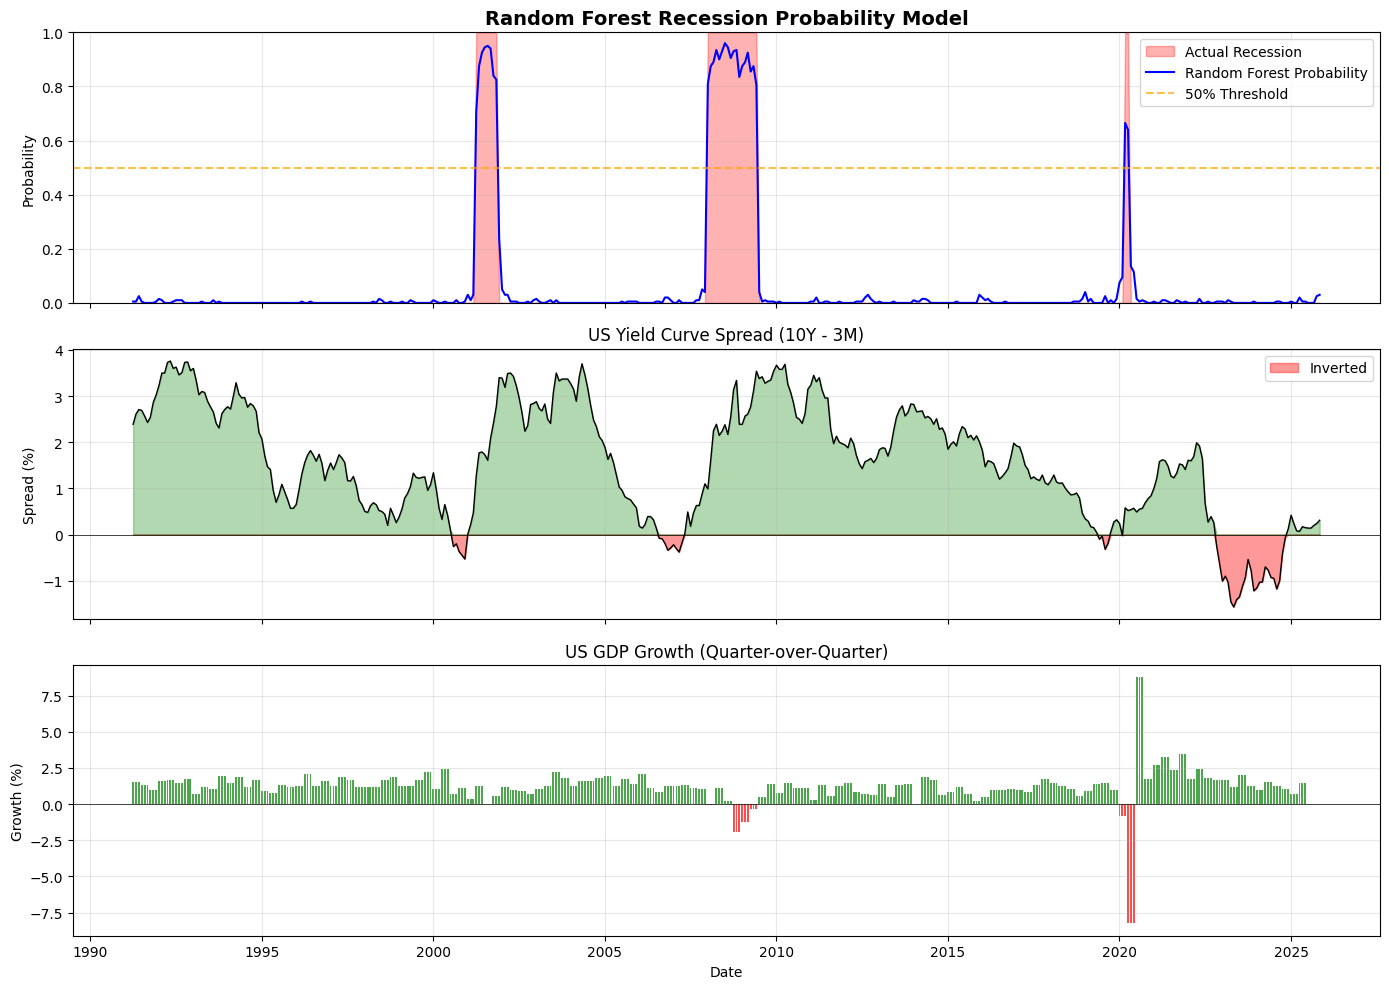

In [25]:
# FUNCTIONALITY: Plots random forest recession probability over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# get probabilities for all data
X_all_scaled = scaler.fit_transform(features)
rf_model.fit(X_all_scaled, target)
all_probs = rf_model.predict_proba(X_all_scaled)[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Recession probability
ax1 = axes[0]
ax1.fill_between(features.index, 0, target.values, alpha=0.3, color='red', label='Actual Recession')
ax1.plot(features.index, all_probs, 'b-', linewidth=1.5, label='Random Forest Probability')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='50% Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('Random Forest Recession Probability Model', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Yield curve spread
ax2 = axes[1]
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(upper=0), alpha=0.4, color='red', label='Inverted')
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(lower=0), alpha=0.3, color='green')
ax2.plot(features.index, features['us_yield_spread'], 'k-', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Spread (%)')
ax2.set_title('US Yield Curve Spread (10Y - 3M)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: GDP growth
ax3 = axes[2]
colors = ['green' if x >= 0 else 'red' for x in features['us_gdp_growth']]
ax3.bar(features.index, features['us_gdp_growth'], width=20, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Growth (%)')
ax3.set_title('US GDP Growth (Quarter-over-Quarter)', fontsize=12)
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

for ax in axes:
  ax.xaxis.set_major_locator(mdates.YearLocator(5))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('rf_recession_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 4.K-Nearest Neighbors classifier

In [22]:
# FUNCTIONALITY: Trains K-Nearest Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

# train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# evaluate
knn_prob = knn_model.predict_proba(X_test_scaled)[:, 1]
knn_pred = knn_model.predict(X_test_scaled)

print(f"AUC-ROC: {roc_auc_score(y_test, knn_prob):.3f}")
print(f"F1 Score: {f1_score(y_test, knn_pred, zero_division=0):.3f}")
print(f"\n{classification_report(y_test, knn_pred, zero_division=0)}")

AUC-ROC: 0.987
F1 Score: 0.444

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       117
         1.0       0.29      1.00      0.44         2

    accuracy                           0.96       119
   macro avg       0.64      0.98      0.71       119
weighted avg       0.99      0.96      0.97       119



# Plot for K-Nearest Neighbor

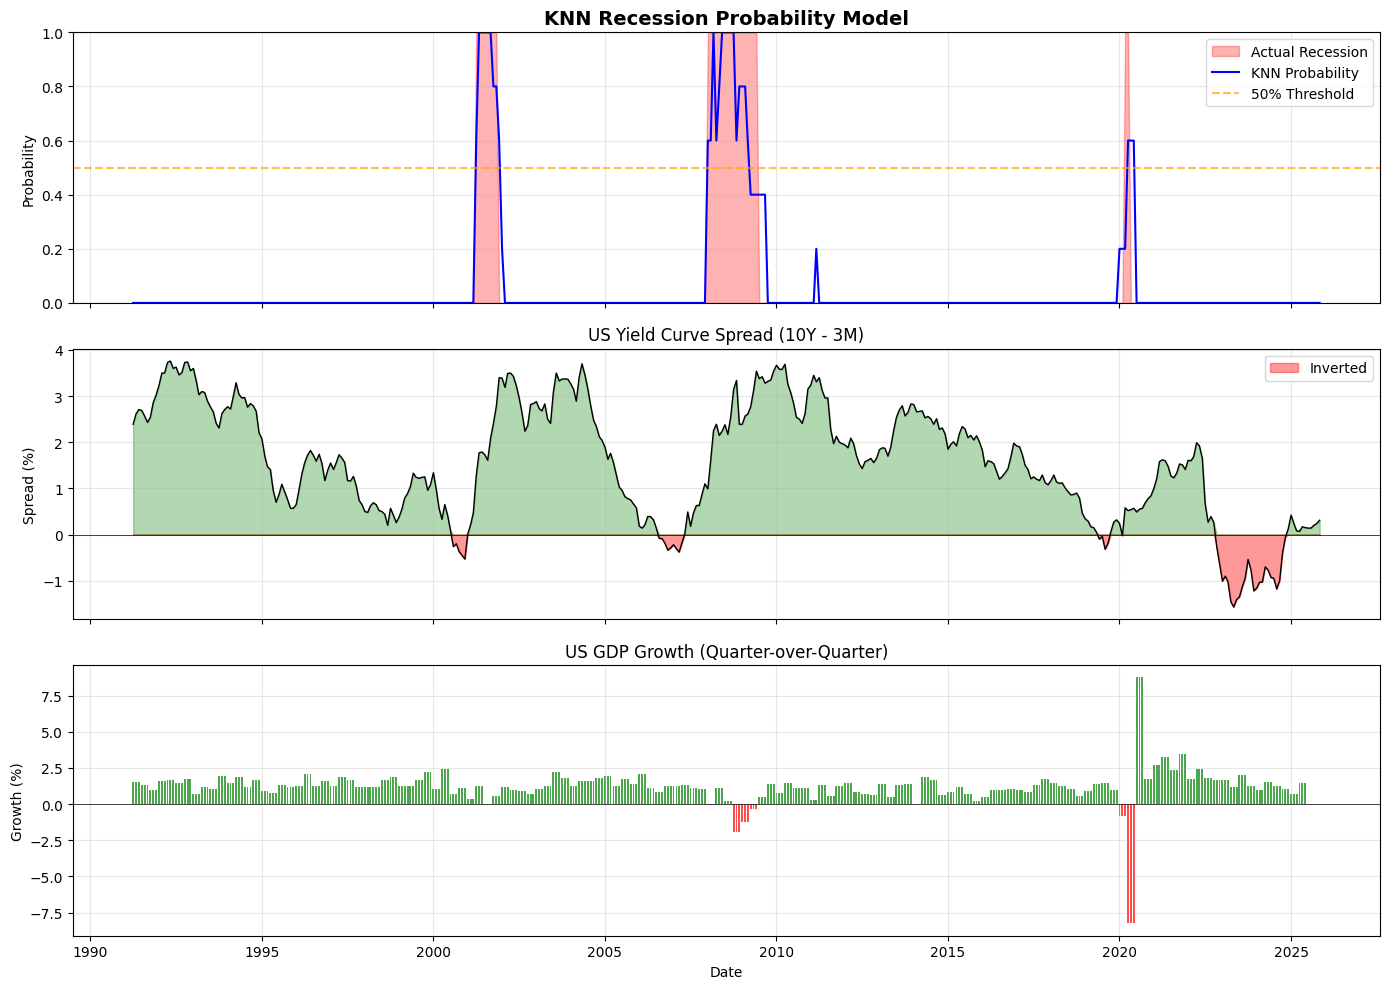

In [23]:
# FUNCTIONALITY: Plots KNN recession probability over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# get probabilities for all data
X_all_scaled = scaler.fit_transform(features)
knn_model.fit(X_all_scaled, target)
all_probs = knn_model.predict_proba(X_all_scaled)[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Recession probability
ax1 = axes[0]
ax1.fill_between(features.index, 0, target.values, alpha=0.3, color='red', label='Actual Recession')
ax1.plot(features.index, all_probs, 'b-', linewidth=1.5, label='KNN Probability')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='50% Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('KNN Recession Probability Model', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Yield curve spread
ax2 = axes[1]
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(upper=0), alpha=0.4, color='red', label='Inverted')
ax2.fill_between(features.index, 0, features['us_yield_spread'].clip(lower=0), alpha=0.3, color='green')
ax2.plot(features.index, features['us_yield_spread'], 'k-', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Spread (%)')
ax2.set_title('US Yield Curve Spread (10Y - 3M)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: GDP growth
ax3 = axes[2]
colors = ['green' if x >= 0 else 'red' for x in features['us_gdp_growth']]
ax3.bar(features.index, features['us_gdp_growth'], width=20, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Growth (%)')
ax3.set_title('US GDP Growth (Quarter-over-Quarter)', fontsize=12)
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

for ax in axes:
  ax.xaxis.set_major_locator(mdates.YearLocator(5))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('knn_recession_analysis.png', dpi=150, bbox_inches='tight')
plt.show()